In [115]:
import pydot
from keras.models import load_model

def plot(model, input_size, to_file):

    graph = pydot.Dot(graph_type='digraph', rankdir="LR")

    previous_node = None
    written_nodes = []
    n = 0
    current_node = pydot.Node("Input (" + str(input_size)+")")
    written_nodes.append("Input (" + str(input_size)+")")
    graph.add_node(current_node)
    if previous_node:
        graph.add_edge(pydot.Edge(previous_node, current_node))
    previous_node = current_node
    for node in model.get_config():
        try:
            reg = str(node['config']['kernel_regularizer']['config']['l1'])
        except:
            reg = ""
        text = str(node['config']['units']) #+ " " +  reg 
        n += 1
        current_node = pydot.Node(str(n) + " (" +text + ")")
        written_nodes.append(str(n) + " (" +text +")")
        graph.add_node(current_node)
        if previous_node:
            graph.add_edge(pydot.Edge(previous_node, current_node))
        previous_node = current_node
    graph.write_png(to_file)
    
model = load_model("model/wavenet_6834.mdl")

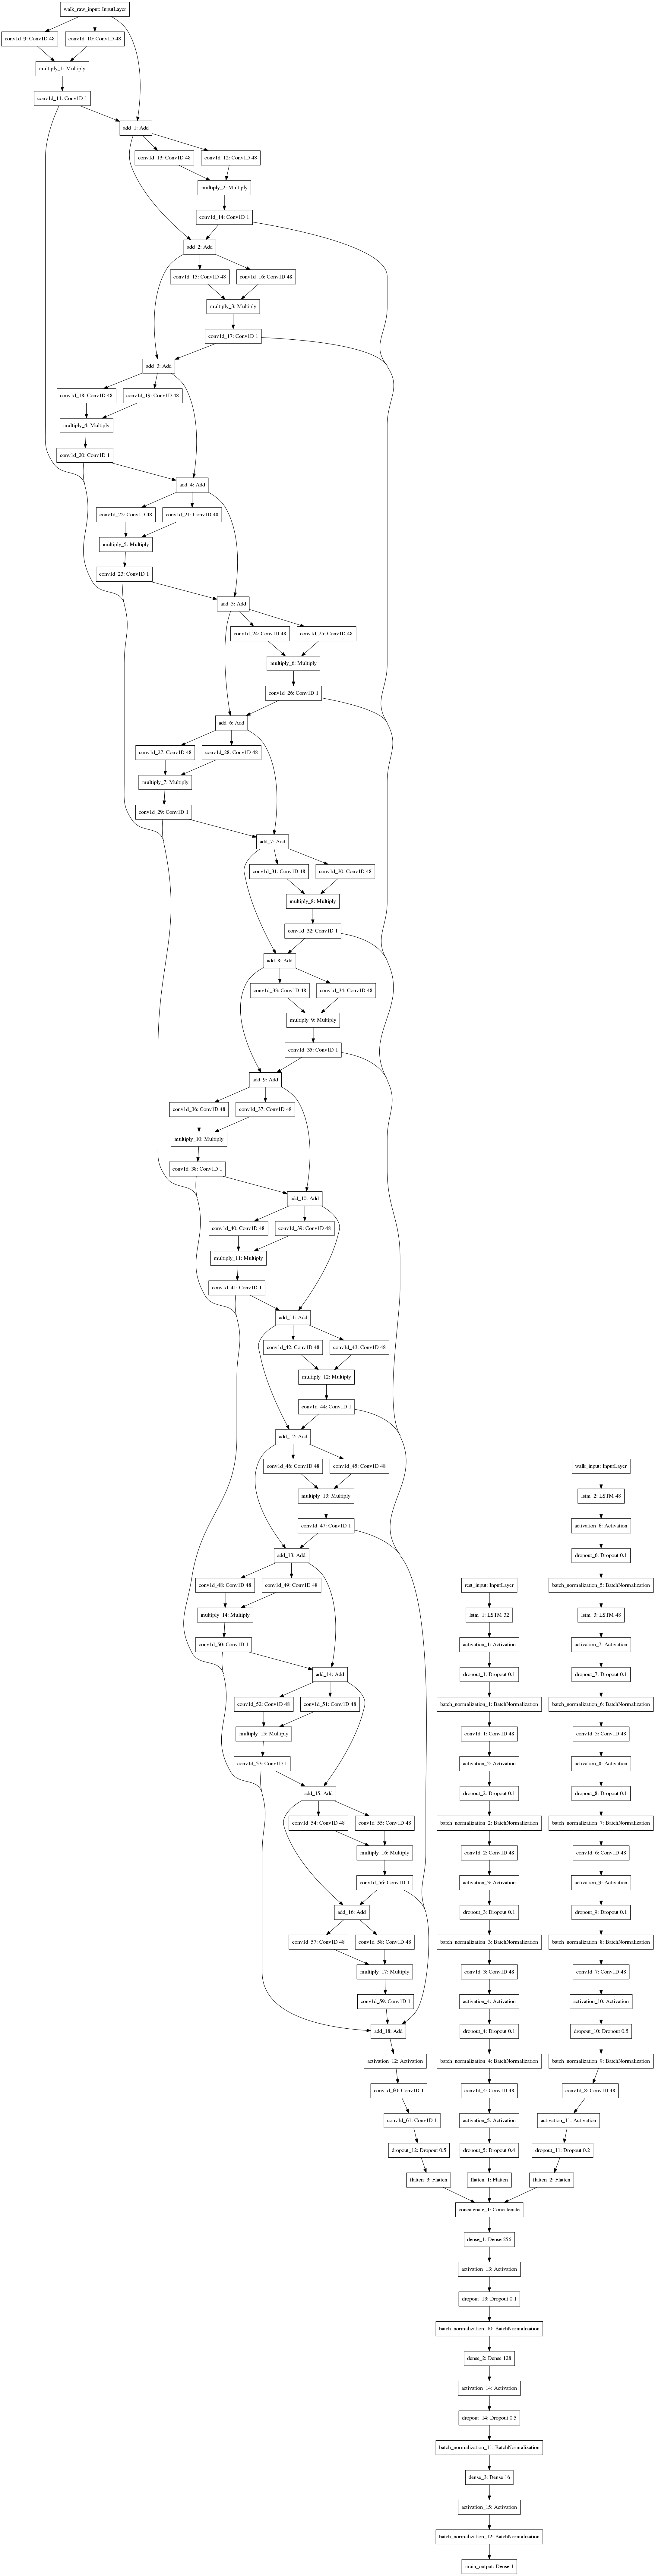

In [116]:
from IPython.display import Image

def _check_pydot():
    try:
        # Attempt to create an image of a blank graph
        # to check the pydot/graphviz installation.
        pydot.Dot.create(pydot.Dot())
    except Exception:
        # pydot raises a generic Exception here,
        # so no specific class can be caught.
        raise ImportError('Failed to import pydot. You must install pydot'
                          ' and graphviz for `pydotprint` to work.')


def model_to_dot(model,
                 show_shapes=False,
                 show_layer_names=True,
                 rankdir='TB'):
    """Convert a Keras model to dot format.
    # Arguments
        model: A Keras model instance.
        show_shapes: whether to display shape information.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot:
            'TB' creates a vertical plot;
            'LR' creates a horizontal plot.
    # Returns
        A `pydot.Dot` instance representing the Keras model.
    """
    from keras.layers.wrappers import Wrapper
    from keras.models import Sequential

    _check_pydot()
    dot = pydot.Dot()
    dot.set('rankdir', rankdir)
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')

    if isinstance(model, Sequential):
        if not model.built:
            model.build()
        model = model.model
    layers = model.layers

    # Create graph nodes.
    for layer in layers:
        layer_id = str(id(layer))

        # Append a wrapped layer's label to node's label, if it exists.
        layer_name = layer.name
        class_name = layer.__class__.__name__
        if isinstance(layer, Wrapper):
            layer_name = '{}({})'.format(layer_name, layer.layer.name)
            child_class_name = layer.layer.__class__.__name__
            class_name = '{}({})'.format(class_name, child_class_name)
        config = layer.get_config()
        extra = ""
        if "filters" in config:
            extra += str(config['filters']) + " "
        if "rate" in config:
            extra += str(config['rate']) + " "
        if "units" in config:
            extra += str(config['units']) + " "
#         print(config)
        # Create node's label.
        if show_layer_names:
            label = '{}: {} {}'.format(layer_name, class_name, extra)
        else:
            label = class_name

        # Rebuild the label as a table including input/output shapes.
        if show_shapes:
            try:
                outputlabels = str(layer.output_shape)
            except AttributeError:
                outputlabels = 'multiple'
            if hasattr(layer, 'input_shape'):
                inputlabels = str(layer.input_shape)
            elif hasattr(layer, 'input_shapes'):
                inputlabels = ', '.join(
                    [str(ishape) for ishape in layer.input_shapes])
            else:
                inputlabels = 'multiple'
            label = '%s\n|{input:|output:}|{{%s}|{%s}}' % (label,
                                                           inputlabels,
                                                           outputlabels)
        node = pydot.Node(layer_id, label=label)
        dot.add_node(node)

    # Connect nodes with edges.
    for layer in layers:
        layer_id = str(id(layer))
        for i, node in enumerate(layer.inbound_nodes):
            node_key = layer.name + '_ib-' + str(i)
            if node_key in model.container_nodes:
                for inbound_layer in node.inbound_layers:
                    inbound_layer_id = str(id(inbound_layer))
                    layer_id = str(id(layer))
                    dot.add_edge(pydot.Edge(inbound_layer_id, layer_id))
    return dot

Image(model_to_dot(model).create(prog='dot', format='png'))
